# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 2.2 MB 9.9 MB/s eta 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/bin/python -m pip install --upgrade pip' command.


In [3]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Already downloaded http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz


# Visualize Data

In [4]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [5]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [6]:
images[0]

'german_shorthaired_57.jpg'

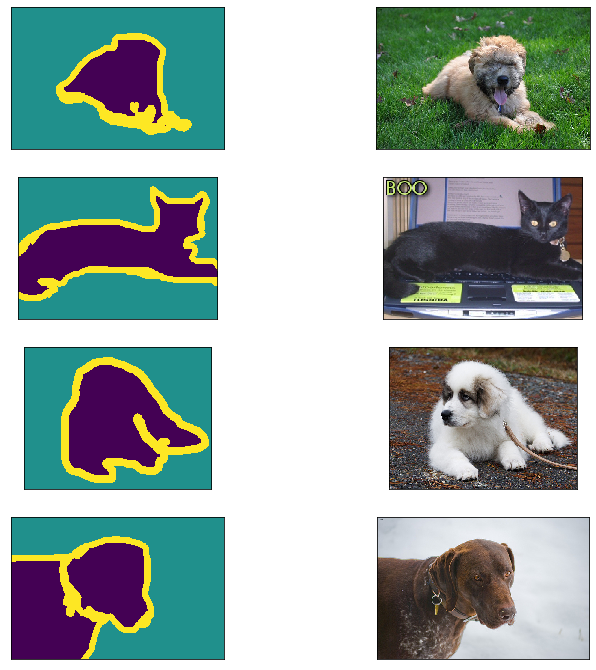

In [9]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [8]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [19]:
role = sagemaker.get_execution_role()
bucket_name = 'petsdata'
#fetch the docker image of the algorithm available in the mentioned region
training_image = get_image_uri(boto3.Session().region_name, 'semantic-segmentation', repo_version='latest') 

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [20]:
print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/semantic-segmentation:latest


In [22]:
# making folders as the semantic segmentation model expects
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [23]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:03<00:00, 1865.13it/s]


In [24]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [25]:
print(len(train_annots), len(train_images))

5551 5551


# Uploading Data to S3

In [27]:
bucket_name ="pets-data-aws"
sess = sagemaker.Session()

print("Starting Upload")
s3_train_path = sess.upload_data(path = 'train', bucket = bucket_name, key_prefix="train")
print("Training images uploaded")
s3_train_annotation_path = sess.upload_data(path = 'train_annotation', bucket = bucket_name, key_prefix="train_annotation")

print("Training annotations uploaded")
s3_validation_path = sess.upload_data(path = 'validation', bucket = bucket_name, key_prefix="validation")
print("Validation images uploaded")
s3_validation_annotation_path = sess.upload_data(path = 'validation_annotation', bucket = bucket_name, key_prefix="validation_annotation")
print("Upload finished")

Starting Upload
Training images uploaded
Training annotations uploaded
Validation images uploaded
Upload finished


# SageMaker Estimator

In [51]:
model = sagemaker.estimator.Estimator(
    training_image,
    role = role,
    train_instance_count = 1,
    train_instance_type = "ml.t3.medium",
    train_volume_size = 100,
    train_max_run = 36000,
    input_mode = "File",
    output_path = "s3://pets-data-aws/output", #trained model will be stored here
    sagemaker_session = sess
)

# Hyperparameters

In [52]:
model.set_hyperparameters(
    backbone = 'resnet-50',
    algorithm = 'fcn', 
    use_pretrained_model = True,
    crop_size=240,
    num_classes = 4,
    epoch=10,
    learning_rate = 0.0001,
    optimizzer = 'rmsprop',
    lr_scheduler = "poly",
    mini_batch= 16,
    validation_mini_batch_size = 16,
    num_training_samples = len(train_images)
)

# Data Channels

In [53]:
train_data = sagemaker.session.s3_input(s3_train_path, distribution = "FullyReplicated", content_type = "image/jpeg", s3_data_type = "S3Prefix")
validation_data = sagemaker.session.s3_input(s3_validation_path, distribution = "FullyReplicated", content_type = "image/jpeg", s3_data_type = "S3Prefix")
train_annotation_data = sagemaker.session.s3_input(s3_train_annotation_path, distribution = "FullyReplicated", content_type = "image/png", s3_data_type = "S3Prefix")
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation_path, distribution = "FullyReplicated", content_type = "image/png", s3_data_type = "S3Prefix")


In [54]:
data_channel = {
    "train": train_data,
    "validation": validation_data,
    "train_annotation" :train_annotation_data,
    "validation_annotation": validation_annotation_data
    
}

In [55]:
data_channel

{'train': <sagemaker.inputs.s3_input at 0x7fae11b8dd68>,
 'validation': <sagemaker.inputs.s3_input at 0x7fae11b8d0f0>,
 'train_annotation': <sagemaker.inputs.s3_input at 0x7fae11b8d0b8>,
 'validation_annotation': <sagemaker.inputs.s3_input at 0x7fae11b8de10>}

# Model Training

In [57]:
model.fit(inputs = data_channel, logs = True)

ClientError: An error occurred (ValidationException) when calling the CreateTrainingJob operation: 1 validation error detected: Value 'ml.t3.medium' at 'resourceConfig.instanceType' failed to satisfy constraint: Member must satisfy enum value set: [ml.p2.xlarge, ml.m5.4xlarge, ml.m4.16xlarge, ml.c5n.xlarge, ml.p3.16xlarge, ml.m5.large, ml.p2.16xlarge, ml.c4.2xlarge, ml.c5.2xlarge, ml.c4.4xlarge, ml.c5.4xlarge, ml.c5n.18xlarge, ml.g4dn.xlarge, ml.g4dn.12xlarge, ml.c4.8xlarge, ml.g4dn.2xlarge, ml.c5.9xlarge, ml.g4dn.4xlarge, ml.c5.xlarge, ml.g4dn.16xlarge, ml.c4.xlarge, ml.g4dn.8xlarge, ml.c5n.2xlarge, ml.c5n.4xlarge, ml.c5.18xlarge, ml.p3dn.24xlarge, ml.p3.2xlarge, ml.m5.xlarge, ml.m4.10xlarge, ml.c5n.9xlarge, ml.m5.12xlarge, ml.m4.xlarge, ml.m5.24xlarge, ml.m4.2xlarge, ml.p2.8xlarge, ml.m5.2xlarge, ml.p3.8xlarge, ml.m4.4xlarge]

# Deploy Model

In [58]:
deployed_model = model.deploy(initial_instance_count=1, instance_type = "ml.m4.xlarge")
print("\nModel Deployed")

ValueError: Estimator is not associated with a training job

# Predictions

In [ ]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

In [59]:
deployed_model.content_type ='image/jpeg'
deployed_model.accept = 'image/png'

NameError: name 'deployed_model' is not defined

In [ ]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [ ]:
mask = np.array(Image.open(io.BytesIO(results)))

In [ ]:
plt.imshow(plt.imread(image_path));

In [ ]:
plt.imshow(mask);

In [60]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)

NameError: name 'deployed_model' is not defined